In [2]:
%matplotlib inline
import numpy as np
import pandas as p
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import random
sns.set_style("white")
sns.set(style="ticks")
from matplotlib import rc
rc('text', usetex=True)
sns.set_color_codes()

In [8]:
import operator as op
def ncr(n, r):
    if r > n: return 0
#     print n, r, n-r
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom

def multinomial(k_list):
    running_prod = 1
    for i in range(len(k_list)):
        running_prod = running_prod * ncr(sum(k_list[:i+1]),k_list[i])
    return running_prod

def strandlength_distribution(NumCells,r,MaxLength):
    
#     unifs = np.random.uniform(0,1,N)
    
    b = r
    g = 1/(float(NumCells)+1)
    
    geometric = [( ((b*(1-g))/(b+g*(1-b)))**k * (g/(b+g*(1-b))) ) for k in range(MaxLength)]
    geometric.append(1-sum(geometric))
#     geometric_cum = np.cumsum(geometric)
    
#     lengths = [np.where(geometric_cum > unif)[0][0] for unif in unifs]
    
    return geometric

def pull_from_strandlength_distribution(N,NumCells,r,MaxLength):
    
    unifs = np.random.uniform(0,1,N)
    
    geometric = strandlength_distribution(NumCells,r,MaxLength)
    
    geometric_cum = np.cumsum(geometric)
    
    lengths = [np.where(unif < geometric_cum)[0][0] for unif in unifs]
    
    return lengths

## Naive method of simulating all strands ##
def old_motif_freq(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    motiffreq = 0
    for k in range(len(motif),maxLength+1):
        lengthlist = map(''.join, itertools.product('10', repeat=k))
#         print lengthlist
#         all_strands = []
#         for pos in range(k-len(motif)):
#             all_strands += [string[:pos] + motif + string[pos:] for string in lengthlist ]
#         lengthlist = np.unique(all_strands)
        lengthlist = [string for string in lengthlist if motif in string]
        strand_probs = [b**(s.count('0'))*(1-b)**(s.count('1'))   for s in lengthlist]
#         print strand_probs
#         print sum(strand_probs)
#         motiffreq = motiffreq + sl_dist[k]*len([s for s in lengthlist if motif in s])/(2.0**k)
        motiffreq = motiffreq + sl_dist[k]*sum([strand_probs[s] for s in range(len(lengthlist)) if motif in lengthlist[s]])
        
    return motiffreq, motiffreq/(1-sl_dist[0])

## Faster Brute force method of simulating the strands ##
def motif_freq(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    motiffreq = 0
    motif_containing_strands = [motif]
    last_length = len(motif)
    last_length_list = [motif]
    for k in range(1,maxLength+1-len(motif)):
        # k is non-motif digits
        lengthlist = map(''.join, itertools.product('10', repeat=k))
#         print last_length_list
#         print lengthlist
        
        new_length_0 = [s + '0' for s in last_length_list]
        new_length_1 = [s + '1' for s in last_length_list]
        
        new_length = [s + motif for s in lengthlist]
        
        last_length_list = new_length_0 + new_length_1
        combined = last_length_list + new_length
#         print list(np.unique([combined[i] for i in range(len(combined)) if combined[i] in (combined[:i] + combined[i+1:])]))
        last_length_list = list(np.unique(last_length_list + new_length))
        
#         print motif_containing_strands
#         print last_length_list
#         print k, len(last_length_list)
        motif_containing_strands += last_length_list
        
#     print motif_containing_strands
    strand_probs = [sl_dist[len(s)]*b**(s.count('0'))*(1-b)**(s.count('1'))   for s in motif_containing_strands]
#     print strand_probs
#         print sum(strand_probs)
#         motiffreq = motiffreq + sl_dist[k]*len([s for s in lengthlist if motif in s])/(2.0**k)
    motiffreq = sum(strand_probs)
        
    return motiffreq, motiffreq/(1-sl_dist[0])

## Analytical Derivation for non-overlapping motifs ##
def motif_freq_analytical(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    
    motiffreq = 0
    
    for lam in range(l,maxLength+1):
        this_length_prob = 0
        
        this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)*sum([ncr(lam-l,k)*b**k*(1-b)**(lam-l-k)  for k in range(lam-l+1)])
        if np.floor(lam/l) >= 2:
            for beta in range(2,np.int(np.floor(lam/l))+1):
                this_length_prob +=  sum([(-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))*sum([ncr(lam-beta*l,k)*b**k*(1-b)**(lam-beta*l-k) for k in range(lam-beta*l+1)])])

        motiffreq += sl_dist[lam]*this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def overlap_detector(motif):
    l = len(motif)
    o_len = 0
    o0 = 0
    for iterator in range(1,l):
        if motif[:l-iterator] == motif[iterator:]:
            o_len = l-iterator
            o0 = motif[:l-iterator].count('0')
            break
    return o_len, o0

## Analytical Derivation for motifs that can only overlap once ##
def motif_freq_analytical_overlap(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len, o0 = overlap_detector(motif)

    motiffreq = 0
    
    for lam in range(l,maxLength+1):
#         print "NEW LENGTH"
        this_length_prob = 0
#         beta_probs = []
#         alpha_probs = []
        
#         this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)
#         if np.floor(lam/l) >= 2:
        for alpha in range(1,np.int(np.floor(lam/l))+1):
#             alpha_probs.append(0)
            if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha:
                for beta in range(alpha,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):
#                     print alpha,beta
#                     print (-1)**(beta+1)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha)*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
#                     alpha_probs[alpha-1] += (-1)**(beta+1)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha)*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
                    this_length_prob +=(-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))

        motiffreq += sl_dist[lam]*this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def multiple_overlap_detector(motif):
    l = len(motif)
    o_len = [0]
    o0 = [0]
    for iterator in range(1,l):
        if motif[:l-iterator] == motif[iterator:]:
            o_len.append(l-iterator)
            o0.append(motif[:l-iterator].count('0'))
    if len(o_len) == 0:
        o_len.append(0)
        o0.append(0)
    return o_len, o0

## Analytical Derivation for motifs with multiple overlaps ##
def motif_freq_analytical_multipleoverlap(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len_list, o0_list = multiple_overlap_detector(motif)
#     print o_len_list
#     print o0_list

    motiffreq = 0
    
    for lam in range(l,maxLength+1):
#         print "NEW LENGTH"
        this_length_prob = 0
#         beta_probs = []
#         alpha_probs = []
        
#         this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)
#         if np.floor(lam/l) >= 2:
        for o_len, o0 in zip(o_len_list,o0_list):
            if o_len == 0:
                if np.floor(lam/l) >= 1:
                    for beta in range(1,np.int(np.floor(lam/l))+1):
                        this_length_prob += (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
            else:
                for alpha in range(1,np.int(np.floor((lam-(l+l-o_len))/l))+2):
    #             alpha_probs.append(0)

                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha:
                        for beta in range(alpha+1,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):

    #                             print 'made it'

        #                     print alpha,beta
        #                     print (-1)**(beta+1)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha)*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
        #                     alpha_probs[alpha-1] += (-1)**(beta+1)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha)*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
                            this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))

        motiffreq += sl_dist[lam]*this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def motif_freq_analytical_multipleoverlap_nosldist_singlel(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len_list, o0_list = multiple_overlap_detector(motif)
#     print o_len_list
#     print o0_list

    motiffreq = 0
    
    for lam in range(maxLength,maxLength+1):
#         print "NEW LENGTH"
        this_length_prob = 0
#         beta_probs = []
#         alpha_probs = []
        
#         this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)
#         if np.floor(lam/l) >= 2:
        for o_len, o0 in zip(o_len_list,o0_list):
            if o_len == 0:
                if np.floor(lam/l) >= 1:
                    for beta in range(1,np.int(np.floor(lam/l))+1):
                        this_length_prob += (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
            else:
                for alpha in range(1,np.int(np.floor((lam-(l+l-o_len))/l))+2):
    #             alpha_probs.append(0)

                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha:
                        for beta in range(alpha+1,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):

    #                             print 'made it'

        #                     print alpha,beta
        #                     print (-1)**(beta+1)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha)*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
        #                     alpha_probs[alpha-1] += (-1)**(beta+1)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha)*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
                            this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))

        motiffreq += this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])


def cells_with_motif(b,motif,numCells,r,maxLength,numStrands):
    
#     b = 0.5

    motif_prob = motif_freq_analytical(b,motif,numCells,r,maxLength)[0]
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    return p_cell_with_motif

def steady_state_motif_dist(b,motif,numCells,r,maxLength,numStrands):
    
    motif_prob, non_empty_motif_freq = motif_freq_analytical(b,motif,numCells,r,maxLength)
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    p_cell_with_motif = cells_with_motif(0.5,motif,numCells,r,maxLength,numStrands)
    
    ss_motif_freq = p_cell_with_motif*non_empty_motif_freq
    
    return ss_motif_freq

# def ss_cells_motif_dist(b,motif,numCells,r,maxLength,numStrands):
    
#     motif_prob, non_empty_motif_freq = motif_freq_analytical(b,motif,numCells,r,maxLength)
    
#     p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
#     ss_motif_freq = p_cell_with_motif*non_empty_motif_freq
    
#     return ss_motif_freq
    

15
(0.3052748936183598, 0.36632987234203174)
(0.30414094519341567, 0.3649691342320988)
(0.30414094519341567, 0.3649691342320988)
16
(0.3061697024181608, 0.367403642901793)
(0.30496153045389857, 0.3659538365446783)
(0.30496153045389857, 0.3659538365446783)
15
(0.0649819883966465, 0.07797838607597579)
(0.06498198839665718, 0.07797838607598861)
16
(0.06624015503617318, 0.07948818604340782)
(0.0662388154442774, 0.07948657853313287)


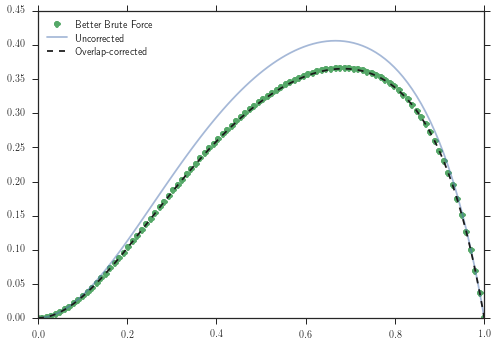

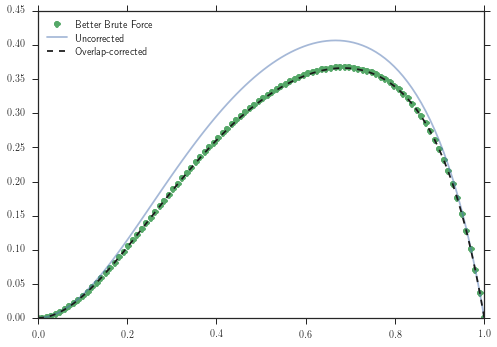

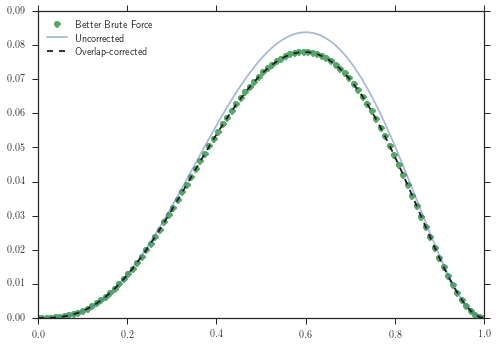

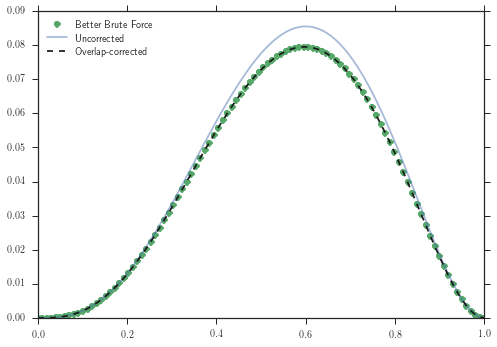

In [4]:
# for i in range(15,17):
#     plt.figure()
#     plt.plot(np.linspace(0.0,1,100),[motif_freq(b,'010',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'go',label='Better Brute Force')
#     plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical(b,'010',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'b',alpha=0.5,label='Uncorrected')
#     plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'010',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'k--',label='Overlap-corrected')
#     plt.legend(loc='upper left')
#     print i
#     print motif_freq(2.0/3,'010',100,0.05,i)
#     print motif_freq_analytical_overlap(2.0/3,'010',100,0.05,i)
#     print motif_freq_analytical_multipleoverlap(2.0/3,'010',100,0.05,i)
for i in range(15,17):
    plt.figure()
    plt.plot(np.linspace(0.0,1,100),[motif_freq(b,'10000',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'go',label='Better Brute Force')
    plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical(b,'10000',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'b',alpha=0.5,label='Uncorrected')
    plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'k--',label='Overlap-corrected')
    plt.legend(loc='upper left')
#     print i
#     print motif_freq(0.6,'10000',100,0.05,i)
#     print motif_freq_analytical_multipleoverlap(0.6,'10000',100,0.05,i)    

for i in range(15,17):
    plt.figure()
    plt.plot(np.linspace(0.0,1,100),[motif_freq(b,'10010',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'go',label='Better Brute Force')
    plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical(b,'10010',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'b',alpha=0.5,label='Uncorrected')
    plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10010',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'k--',label='Overlap-corrected')
    plt.legend(loc='upper left')
    print i
    print motif_freq(0.6,'10010',100,0.05,i)
    print motif_freq_analytical_multipleoverlap(0.6,'10010',100,0.05,i)
    
# for i in range(10,20):
#     plt.figure()
#     plt.plot(np.linspace(0.0,1,100),[motif_freq(b,'10000',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'go',label='Better Brute Force')
#     plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical(b,'10000',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'b',alpha=0.5,label='Uncorrected')
#     plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,i)[1] for b in np.linspace(0.0,1,100)],'k--',label='Overlap-corrected')
#     plt.legend(loc='upper left')
#     print i
#     print motif_freq(0.6,'10000',100,0.05,i)
#     print motif_freq_analytical_multipleoverlap(0.6,'10000',100,0.05,i)

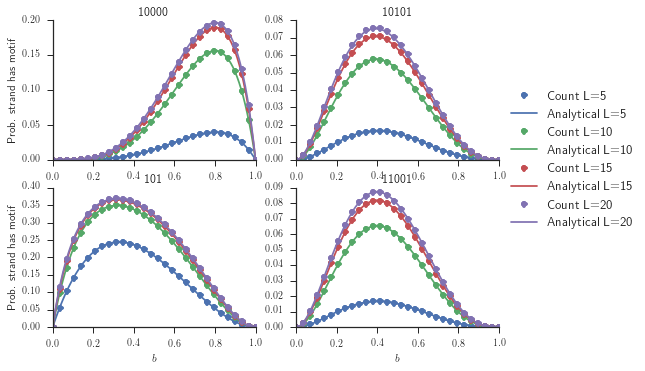

In [28]:
ax = plt.figure()
plt.subplot(221)
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')


plt.ylabel('Prob. strand has motif')
plt.title('10000')
plt.subplot(222)
# plt.figure()
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')


plt.title('10101')

# plt.figure()
plt.subplot(223)
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')


plt.title('101')
plt.ylabel('Prob. strand has motif')
plt.xlabel('$b$')

# plt.figure()
ax = plt.subplot(224)
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Count L=5')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=5')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Count L=10')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical L=10')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Count L=15')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical L=15')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')
# ax.text(-0.1, 0, 'd', 
#             size=20, weight='bold')
plt.title('11001')
plt.xlabel('$b$')
# ax.axis["right"].set_visible(False)
# ax.axis["top"].set_visible(False)
sns.despine(top=True,right=True)
plt.legend(loc='center left',ncol=1,fontsize=13,bbox_to_anchor=(1, 1.2))
plt.savefig('analytical_comparison_many.pdf',bbox_inches='tight')

In [14]:
multiple_overlap_detector('0000')

([0, 3, 2, 1], [0, 3, 2, 1])

In [198]:
plt.figure()
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,4)[1] for b in np.linspace(0.0,1,50)],'bo',label='Brute Force Count, L=5')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'0000',100,0.05,4)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=5')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,5)[1] for b in np.linspace(0.0,1,50)],'bo',label='Brute Force Count, L=5')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'0000',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=5')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,6)[1] for b in np.linspace(0.0,1,50)],'bo',label='Brute Force Count, L=6')
# # plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial(b,'0000',100,0.05,6)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=6')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,7)[1] for b in np.linspace(0.0,1,50)],'go',label='Brute Force Count, L=7')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial(b,'0000',100,0.05,7)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical L=7')

motif_freq_analytical_multipleoverlap_trial2(1.0,'0000',100,0.05,9)
# motif_freq_analytical_multipleoverlap_trial(1.0,'0000000',100,0.05,7)
# motif_freq_analytical_multipleoverlap_trial(1.0,'000000',100,0.05,7)
# motif_freq_analytical_multipleoverlap_trial(1.0,'00000',100,0.05,8)
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,7)[1] for b in np.linspace(0.0,1,50)],'bo',label='Brute Force Count, L=8')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial2(b,'0000',100,0.05,7)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=8')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,8)[1] for b in np.linspace(0.0,1,50)],'ro',label='Brute Force Count, L=8')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial2(b,'0000',100,0.05,8)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical L=8')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,9)[1] for b in np.linspace(0.0,1,50)],'ko',label='Brute Force Count, L=9')
print 'lambda9'
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial2(b,'0000',100,0.05,9)[1] for b in np.linspace(0.0,1,100)],'k',label='Analytical L=9')


# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial2(b,'0000',100,0.05,9)[1] for b in np.linspace(0.0,1,100)],'k',label='Analytical L=9')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,10)[1] for b in np.linspace(0.0,1,50)],'go',label='Brute Force Count, L=10')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial(b,'0000',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical L=10')
# plt.plot(np.linspace(0.0,1,50),[motif_freq(b,'0000',100,0.05,11)[1] for b in np.linspace(0.0,1,50)],'bo',label='Brute Force Count, L=11')
# plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_trial(b,'0000',100,0.05,11)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=11')
# plt.legend(loc='upper left')
# plt.title('0000 motif')
# plt.savefig('0000_analytical.pdf',bbox_inches='tight')

lambda 4
No overlap
BETA 1
1.0
Overlap 1
Overlap 1
Overlap 1
2 overlap sizes
3 2
2 1
3 1
THIS LEN 1.0
lambda 5
No overlap
BETA 1
2.0
Overlap 1
ALPHA 1
BETA 2
-1.0
Overlap 1
Overlap 1
2 overlap sizes
3 2
2 1
3 1
THIS LEN 1.0
lambda 6
No overlap
BETA 1
3.0
Overlap 1
ALPHA 1
BETA 2
-2.0
ALPHA 1
BETA 3
1.0
Overlap 1
ALPHA 1
BETA 2
-1.0
Overlap 1
2 overlap sizes
3 2
2 1
3 1
THIS LEN 1.0
lambda 7
No overlap
BETA 1
4.0
Overlap 1
ALPHA 1
BETA 2
-3.0
ALPHA 1
BETA 3
2.0
ALPHA 1
BETA 4
-1.0
Overlap 1
ALPHA 1
BETA 2
-2.0
Overlap 1
ALPHA 1
BETA 2
-1.0
2 overlap sizes
3 2
alpha 1
c  0
beta 3
2.0
2 1
3 1
THIS LEN 1.0
lambda 8
No overlap
BETA 1
5.0
BETA 2
-1.0
Overlap 1
ALPHA 1
BETA 2
-4.0
ALPHA 1
BETA 3
3.0
ALPHA 1
BETA 4
-2.0
ALPHA 1
BETA 5
1.0
Overlap 1
ALPHA 1
BETA 2
-3.0
ALPHA 1
BETA 3
1.0
Overlap 1
ALPHA 1
BETA 2
-2.0
2 overlap sizes
3 2
alpha 1
c  0
beta 3
4.0
alpha 1
c  0
beta 4
-3.0
2 1
3 1
alpha 1
c  0
beta 3
2.0
THIS LEN 1.0
lambda 9
No overlap
BETA 1
6.0
BETA 2
-3.0
Overlap 1
ALPHA 1
BETA 

In [197]:
def multiple_overlap_detector(motif):
    l = len(motif)
    o_len = [0]
    o0 = [0]
    for iterator in range(1,l):
        if motif[:l-iterator] == motif[iterator:]:
            o_len.append(l-iterator)
            o0.append(motif[:l-iterator].count('0'))
    if len(o_len) == 0:
        o_len.append(0)
        o0.append(0)
    return o_len, o0

def shift(l,n):
    return l[n:] + l[:n]

## Analytical Derivation for motifs with multiple overlaps ##
def motif_freq_analytical_multipleoverlap_trial(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len_list, o0_list = multiple_overlap_detector(motif)
#     o_len_list = o_len_list[:len(o_len_list)-1]
#     o0_list = o0_list[:len(o0_list)-1]
#     print o_len_list
#     print o0_list

    o_len_doubled = o_len_list

    motiffreq = 0
    
    for lam in range(l,maxLength+1):
#         print "NEW LENGTH"
        this_length_prob = 0
#         print 'lambda', lam
#         beta_probs = []
#         alpha_probs = []
        
#         this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)
#         if np.floor(lam/l) >= 2:
        for o_len, o0 in zip(o_len_list,o0_list):
            if o_len == 0:
                if np.floor(lam/l) >= 1:
                    for beta in range(1,np.int(np.floor(lam/l))+1):
                        this_length_prob += (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
            else:
                for alpha in range(1,np.int(np.floor((lam-(l+l-o_len))/l))+2):
    #             alpha_probs.append(0)

                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha+1:
                        for beta in range(alpha+1,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):

    #                             print 'made it'
#                             print (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))\
#                                     *b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
 
                            this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))\
                                    *b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
        if len(o_len_list) > 2:
            ThetaCrossTheta = zip(o_len_list[1:],shift(o_len_list[1:],1))
            ThetaCrossTheta_0 = zip(o0_list[1:],shift(o0_list[1:],1))
            for pairing in zip(ThetaCrossTheta,ThetaCrossTheta_0):
                o_len_pair = list(pairing[0])
                o0_pair = list(pairing[1])
    #             print o0_pair
                v1 = max(o_len_pair)
                max_index = o_len_pair.index(v1)
                v2 = min(o_len_pair)
                min_index = o_len_pair.index(v2)
                v1_0 = o0_pair[max_index]
                v2_0 = o0_pair[min_index]
#                 print v1, v2
    #             print v1_0
    #             print v2
    #             print v2_0
    #             print 'before it all'

                for alpha in range(1,np.int(np.floor((lam-(l+l-v1+l-v2))/l))+2):
                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha+1:
                        for beta in range(alpha+2,alpha+2+np.int(np.floor((lam-alpha*l-(l-v1)-(l-v2))/(l-v1)))+1):
                            for c in range(0,np.int(np.floor((lam-alpha*l-(l-v1)-(l-v2))/(l-v2)))+1):
    #                             print 'here'
    #                             print 'c ', c
    #                             print beta
    #                             print ncr(lam-alpha*l-(beta-alpha-2-c+1)*(l-v1)-(c+1)*(l-v2)+alpha,alpha)
    #                             print (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(beta-alpha,c+1)*ncr(lam-alpha*l-(beta-alpha-2-c+1)*(l-v1)-(c+1)*(l-v2)+alpha,alpha))\
    #                                 *b**(alpha*m0+(beta-alpha-2-c+1)*(m0-v1_0)+(c+1)*(m0-v2_0))*(1-b)**(alpha*(l-m0)+(beta-alpha-2-c+1)*(l-m0-(v1-v1_0))+(c+1)*(l-m0-(v2-v2_0)))
                                
                                this_length_prob += (-1)**(beta+1)*(ncr(beta-1,alpha-1)*math.factorial(beta-alpha)*ncr(lam-alpha*l-(beta-alpha-2-c+1)*(l-v1)-(c+1)*(l-v2)+alpha,alpha))\
                                    *b**(alpha*m0+(beta-alpha-2-c+1)*(m0-v1_0)+(c+1)*(m0-v2_0))*(1-b)**(alpha*(l-m0)+(beta-alpha-2-c+1)*(l-m0-(v1-v1_0))+(c+1)*(l-m0-(v2-v2_0)))
        if len(o_len_list) > 3:
            ThetaCross3 = zip(o_len_list[1:],shift(o_len_list[1:],1),shift(o_len_list[1:],2))
            ThetaCross3_0 = zip(o0_list[1:],shift(o0_list[1:],1),shift(o0_list[1:],2))
            for trio in zip(ThetaCross3,ThetaCross3_0):
                o_len_pair = list(pairing[0])
                o0_pair = list(pairing[1])
                index_list = [i[0] for i in sorted(enumerate(o_len_pair), key=lambda x:x[1])]
                print index_list

#         print 1
#         if this_length_prob < 0:
#             this_length_prob = -1*this_length_prob
        motiffreq += sl_dist[lam]*this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def motif_freq_analytical_multipleoverlap_trial2(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len_list, o0_list = multiple_overlap_detector(motif)
#     o_len_list = o_len_list[:len(o_len_list)-1]
#     o0_list = o0_list[:len(o0_list)-1]
#     print o_len_list
#     print o0_list

    o_len_doubled = o_len_list

    motiffreq = 0
    
    for lam in range(l,maxLength+1):
#         print "NEW LENGTH"
        this_length_prob = 0
        print 'lambda', lam
#         beta_probs = []
#         alpha_probs = []
        
#         this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)
#         if np.floor(lam/l) >= 2:
        for o_len, o0 in zip(o_len_list,o0_list):
            if o_len == 0:
                print 'No overlap'
                if np.floor(lam/l) >= 1:
                    for beta in range(1,np.int(np.floor(lam/l))+1):
                        print 'BETA', beta
                        print (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
                        this_length_prob += (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
            else:
                print 'Overlap 1'
                for alpha in range(1,np.int(np.floor((lam-(l+l-o_len))/l))+2):
    #             alpha_probs.append(0)

                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha+1:
                        for beta in range(alpha+1,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):
                            print 'ALPHA', alpha
                            print "BETA", beta
    #                             print 'made it'
                            print (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))\
                                    *b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
             
                            this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))\
                                    *b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))
        if len(o_len_list) > 2:
            print '2 overlap sizes'
            ThetaCrossTheta = zip(o_len_list[1:],shift(o_len_list[1:],1))
            ThetaCrossTheta_0 = zip(o0_list[1:],shift(o0_list[1:],1))
            for pairing in zip(ThetaCrossTheta,ThetaCrossTheta_0):
                o_len_pair = list(pairing[0])
                o0_pair = list(pairing[1])
    #             print o0_pair
                v1 = max(o_len_pair)
                max_index = o_len_pair.index(v1)
                v2 = min(o_len_pair)
                min_index = o_len_pair.index(v2)
                v1_0 = o0_pair[max_index]
                v2_0 = o0_pair[min_index]
                print v1, v2
    #             print v1_0
    #             print v2
    #             print v2_0
    #             print 'before it all'

                for alpha in range(1,np.int(np.floor((lam-(l+l-v1+l-v2))/l))+2):
                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha+1:
                        for beta in range(alpha+2,alpha+2+np.int(np.floor((lam-alpha*l-(l-v1)-(l-v2))/(l-v1)))+1):
                            for c in range(0,np.int(np.floor((lam-alpha*l-(l-v1)-(l-v2))/(l-v2)))+1):
                                print 'alpha',alpha
                                print 'c ', c
                                print 'beta', beta
    #                             print ncr(lam-alpha*l-(beta-alpha-2-c+1)*(l-v1)-(c+1)*(l-v2)+alpha,alpha)
                                print (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(beta-alpha,c+1)*ncr(lam-alpha*l-(beta-alpha-2-c+1)*(l-v1)-(c+1)*(l-v2)+alpha,alpha))\
                                    *b**(alpha*m0+(beta-alpha-2-c+1)*(m0-v1_0)+(c+1)*(m0-v2_0))*(1-b)**(alpha*(l-m0)+(beta-alpha-2-c+1)*(l-m0-(v1-v1_0))+(c+1)*(l-m0-(v2-v2_0)))

                                this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(beta-alpha,c+1)*ncr(lam-alpha*l-(beta-alpha-2-c+1)*(l-v1)-(c+1)*(l-v2)+alpha,alpha))\
                                    *b**(alpha*m0+(beta-alpha-2-c+1)*(m0-v1_0)+(c+1)*(m0-v2_0))*(1-b)**(alpha*(l-m0)+(beta-alpha-2-c+1)*(l-m0-(v1-v1_0))+(c+1)*(l-m0-(v2-v2_0)))


        print 'THIS LEN',this_length_prob
#         if this_length_prob < 0:
#             this_length_prob = -1*this_length_prob
        motiffreq += sl_dist[lam]*this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

In [65]:
zip(list(np.sort(zip([1,2,3],[2,3,1]))),zip([1,2,3],[1,2,3]))

[(array([1, 2]), (1, 1)), (array([2, 3]), (2, 2)), (array([1, 3]), (3, 3))]

In [148]:
multinomial([10,2,4])

120120

0.553586127007
0.999999901201


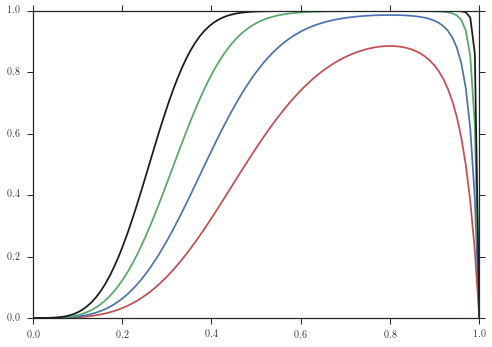

In [205]:
N = 1.0
print cells_with_motif(0.5,'10000',100,0.05,7,25)
print cells_with_motif(0.5,'10000',100,0.05,7,500)
plt.plot(np.linspace(0,1.0,100),[cells_with_motif(b,'10000',100,0.05,7,25) for b in np.linspace(0,1.0,100)],'r',label='Analytical')
plt.plot(np.linspace(0,N,100),[cells_with_motif(b,'10000',100,0.05,7,50) for b in np.linspace(0,N,100)],'b',label='Analytical')
plt.plot(np.linspace(0,N,100),[cells_with_motif(b,'10000',100,0.05,7,100) for b in np.linspace(0,N,100)],'g',label='Analytical')
plt.plot(np.linspace(0,N,100),[cells_with_motif(b,'10000',100,0.05,7,200) for b in np.linspace(0,N,100)],'k',label='Analytical')

In [ ]:
def cells_with_motif(b,motif,numCells,r,maxLength,numStrands):
    
#     b = 0.5

    motif_prob = motif_freq_analytical(b,motif,numCells,r,maxLength)[0]
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    return p_cell_with_motif

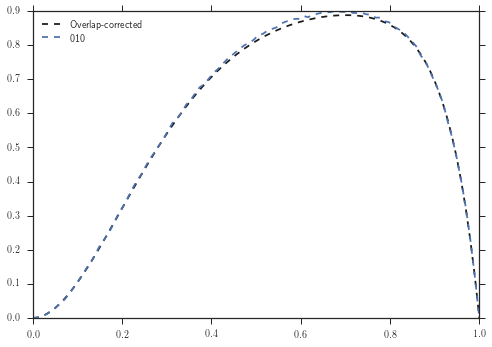

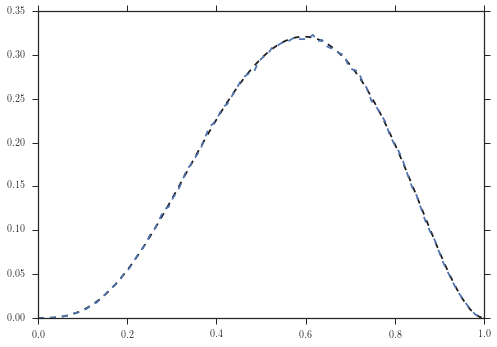

In [11]:
def count_pattern(string,pattern):
    count=0
    for i in range(len(string)):
        if string[i:i+len(pattern)]==pattern:
            count+=1
    return count

def compute_pattern_prob(l,b,pattern):
    population=[]
    pop_size=40000
    for i in range(pop_size):
        sequence=""
        for j in range(l):
            if random.random()<b:
                sequence+="0"
            else:
                sequence+="1"
        #sequence+=sequence[:len(pattern)]
        population.append(sequence)
        
    freq=0
    for seq in population:
        if pattern in seq:
            #freq+=count_pattern(seq,pattern)
            freq+=1
    return freq*1./pop_size
        

patterns=["010","10010"]
dp={}
for pattern in patterns:
    dp[pattern]=[]
    dp[pattern+"est"]=[]
    for b in np.linspace(0.0,1,100):
        num_0=pattern.count("0")
        dp[pattern].append(compute_pattern_prob(15,b,pattern))
       # dp[pattern+"est"].append(compute_estimate(len(pattern),b,num_0,15,compute_self_overlap(pattern)))
i=15
plt.figure()

plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_nosldist_singlel(b,'010',100,0.05,i)[0] for b in np.linspace(0.0,1,100)],'k--',label='Overlap-corrected')
plt.plot(np.linspace(0.0,1,100),dp["010"],"x--",label="010")

plt.legend(loc='upper left')


i=15
plt.figure()
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap_nosldist_singlel(b,'10010',100,0.05,i)[0] for b in np.linspace(0.0,1,100)],'k--',label='Overlap-corrected')
plt.plot(np.linspace(0.0,1,100),dp["10010"],"x--",label="10010")